# KNN: the simplest variation
<div class = "alert alert-block alert-info">Note: here a little inheritance trick is used in order to document KNN class.</div><br>

## Overall
This is a K-nearest-neighbors classifier is one of the simplest **non-parametric** classifiers (number of model's parameters grow with the amount of training data). Non-parametric models are more flexible (because they make less/no assumptions about the nature of given data), but often computationally intractable for large datasets.
KNN counts how many members of each class are in this set, and returns that empirical fraction as the estimate. More formally,
![](img/f1.png)
where $N_K(\mathbf{x}, \mathcal{D})$ are the (indices of the) K nearest points to $\mathbf{x}$ in $\mathcal{D}$ and $\mathbb{I}(e)$ is an indicator function defined as follows:
![](img/f2.png)
This method is an example of **memory-based learning** or **instance-based learning**, which basically means that the algorithm does not really learn but rather *memorizes* training instances and compares new problem to them (instead of performing explicit generalization, compares new problem instances with instances seen in training, which have been stored in memory).

## Algorithm
Let's implement the simples KNN algorithm with Euclidian distance metrics.

In [1]:
# NumPy
import numpy as np

# Plotting
from matplotlib import pyplot as plt
import time
import pylab as pl
from IPython import display
%matplotlib inline

# For inheritence purposes
from abc import ABCMeta, abstractmethod

# Randomizing
from random import randint, choice

from operator import itemgetter

Firs of all we create a method to initiate our KNN class. It will only get a number of neighbors to look at.

In [2]:
class KNN:
    @abstractmethod
    def __init__(self, n_neighbors=5):
        self.X = None
        self.y = None
        self.K = n_neighbors

Now we define the function to fit our model to training set - the fit() function. Actually in this case there is no "fitting" per se, it just memorizes X and y, that is all. 

In [3]:
class KNN(KNN):
    @abstractmethod
    def fit(self, X_train, y_train):
        self.X = np.array(X_train)
        self.y = np.array(y_train)

Let us now define a predicting method.<br><br>
**Important: tie breaking.**<br>
When observation $\mathbf{x}$ has 2 or more "most frequent" classes (for example, out of its 6 nearest neighbors, 3 belong to class $A$ and 3 others belong to class $B$) it's a tie. In this case it is resolved somewhat randomly, because in our case we use set function to count most common elements and it depends on how set will work.<br>
In general the way how you break a tie depends on your data and client requirements. You can assign all ties to some class $Z$, or get the first most common frequent met, etc.

In [4]:
class KNN(KNN):
    @abstractmethod
    def predict(self, usr_X):
        # 0. Do we have matrix X as an input, or just single vector x?
        if np.array(usr_X).ndim == 1: # vector
            X = np.array([usr_X[:]])
        else:                         # matrix
            X = np.array(usr_X[:])
        res = []
        # Loop through each point in X (or once if provided vector x)
        for x in X:
            # 1. First of all we create a dictionary of indices and distances, where
            #    for each observation at X (or for vector x):
            #    {0: d_0} - meaning distance between x and self.X[0] is d_0
            #    {1: d_1} - meaning distance between x and self.X[1] is d_1
            #    {2: d_2} - meaning distance between x and self.X[2] is d_2
            #    etc.
            distances = []
            for observation in self.X:
                distances.append(np.linalg.norm(observation - x))
            dist_dictionary = dict(enumerate(distances))
            # 2. Sort distances and get K nearest neighbors EXCEPT for dist=0.0 of course:
            dist_tuples = sorted(dist_dictionary.items(), key=itemgetter(1))[1:self.K + 1]
            # Now it's list of K tuples like [(4, 2.17),(2, 12.5),(18, 34.5)] showing
            # indices of K closest neighbors and distances to those neighbors.
            # 3. Find out the most common class within those K nearest neighbors:
            y_s = list(map(lambda index: self.y[index], [elem[0] for elem in dist_tuples]))
            # y_s is a list that holds K most common classes, like [0, 3, 0]
            res.append(max(set(y_s), key=y_s.count))
        return res

And a simple scoring method:

In [5]:
class KNN(KNN):
    @abstractmethod
    def score(self, X_test, y_test):
        # 1. Get a prediction:
        y_pred = self.predict(X_test)
        # 2. Compare results:
        match_counter = 0
        for y_pred_i, y_i in zip(y_pred, y_test):
            if y_pred_i == y_i:
                match_counter += 1
        return match_counter / len(y_test)

## Testing
Imports for testing purposes:

In [6]:
from sklearn.model_selection import train_test_split

### Predefined data
For starters we will create simple predefined data with 8 points and 3 classes.

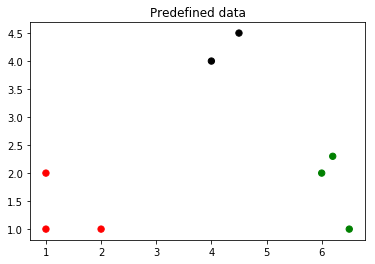

In [7]:
# Predefined data
X = [[1, 1], [1, 2], [2, 1], [4, 4], [4.5, 4.5], [6.5, 1], [6.2, 2.3], [6, 2]]
y = [0, 0, 0, 1, 1, 2, 2, 2]
xs = np.array([point[0] for point in X])
ys = np.array([point[1] for point in X])
classes = np.array(y)
colormap = np.array(['r', 'k', 'g'])
plt.scatter(xs, ys, c=colormap[classes], s=40)
plt.title('Predefined data')
plt.show()

In [8]:
knn = KNN(n_neighbors=2)
knn.fit(X, y)
print("K = 2\nPredictions:", knn.predict(X))
print("   Actual y:", y)
print("      Score:", knn.score(X, y))
knn = KNN(n_neighbors=3)
knn.fit(X, y)
print("K = 3\nPredictions:", knn.predict(X))
print("   Actual y:", y)
print("      Score:", knn.score(X, y))

K = 2
Predictions: [0, 0, 0, 1, 1, 2, 2, 2]
   Actual y: [0, 0, 0, 1, 1, 2, 2, 2]
      Score: 1.0
K = 3
Predictions: [0, 0, 0, 2, 2, 2, 2, 2]
   Actual y: [0, 0, 0, 1, 1, 2, 2, 2]
      Score: 0.75


### Unknown data
Now we will create some random data points and 4 different classes and run our KNN and scikit-learn KNN on it:

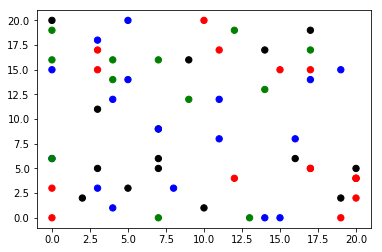

In [9]:
# Get some random points belonging to 3 different classes
X = []
y = []
all_classes = [0, 1, 2, 3]
for i in range(0, 60):
    X.append([randint(0, 20), randint(0, 20)])
    y.append(choice(all_classes))
xs = np.array([point[0] for point in X])
ys = np.array([point[1] for point in X])
classes = np.array(y)
colormap = np.array(['r', 'k', 'g', 'b'])
plt.scatter(xs, ys, c=colormap[classes], s=40)
plt.show()

# Split X, y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=45, test_size=15)

In [10]:
knn = KNN(n_neighbors=3)
knn.fit(X_train, y_train)
print("K = 3\nScore:", knn.score(X_test, y_test))
knn = KNN(n_neighbors=4)
knn.fit(X_train, y_train)
print("K = 4\nScore:", knn.score(X_test, y_test))
knn = KNN(n_neighbors=5)
knn.fit(X_train, y_train)
print("K = 4\nScore:", knn.score(X_test, y_test))

K = 3
Score: 0.2
K = 4
Score: 0.3333333333333333
K = 4
Score: 0.2


## Appendix
Code for short KNN class.

In [11]:
import numpy as np
from operator import itemgetter


class KNN:
    def __init__(self, n_neighbors=5):
        self.X = None
        self.y = None
        self.K = n_neighbors

    def fit(self, X_train, y_train):
        self.X = X_train
        self.y = y_train

    def predict(self, usr_X):
        # 0. Do we have matrix X as an input, or just single vector x?
        if np.array(usr_X).ndim == 1: # vector
            X = np.array([usr_X[:]])
        else:                         # matrix
            X = np.array(usr_X[:])
        res = []
        # Loop through each point in X (or once if provided vector x)
        for x in X:
            # 1. First of all we create a dictionary of indices and distances, where
            #    for each observation at X (or for vector x):
            #    {0: d_0} - meaning distance between x and self.X[0] is d_0
            #    {1: d_1} - meaning distance between x and self.X[1] is d_1
            #    {2: d_2} - meaning distance between x and self.X[2] is d_2
            #    etc.
            distances = []
            for observation in self.X:
                distances.append(np.linalg.norm(observation - x))
            dist_dictionary = dict(enumerate(distances))
            # 2. Sort distances and get K nearest neighbors EXCEPT for dist=0.0 of course:
            dist_tuples = sorted(dist_dictionary.items(), key=itemgetter(1))[1:self.K + 1]
            # Now it's list of K tuples like [(4, 2.17),(2, 12.5),(18, 34.5)] showing
            # indices of K closest neighbors and distances to those neighbors.
            # 3. Find out the most common class within those K nearest neighbors:
            y_s = list(map(lambda index: self.y[index], [elem[0] for elem in dist_tuples]))
            # y_s is a list that holds K most common classes, like [0, 3, 0]
            res.append(max(set(y_s), key=y_s.count))
        return res

    def score(self, X_test, y_test):
        # 1. Get a prediction:
        y_pred = self.predict(X_test)
        # 2. Compare results:
        match_counter = 0
        for y_pred_i, y_i in zip(y_pred, y_test):
            if y_pred_i == y_i:
                match_counter += 1
        return match_counter / len(y_test)

## Resources:
Machine learning : a probabilistic perspective / Kevin P. Murphy.<br>
ISBN 978-0-262-01802-9 (hardcover : alk. paper)<br>
Q325.5.M87 2012<br>
006.3’1—dc23<br>
2012004558